## Imported Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
pd.set_option("display.max_rows", 200)
plt.style.use('seaborn-v0_8-darkgrid')


## Read CSV File

In [35]:
df = pd.read_csv("FIES PUF 2012 Vol.1.CSV")
df

,W_REGN,W_OID,W_SHSN,W_HCN,URB,RSTR,PSU,BWEIGHT,RFACT,FSIZE,...,PC_QTY,OVEN_QTY,MOTOR_BANCA_QTY,MOTORCYCLE_QTY,POP_ADJ,PCINC,NATPC,NATDC,REGDC,REGPC
0,14,101001000,2,25,2,21100,415052,138.25,200.6576,3.0,...,01,01,,,0.946172,108417.00,9,8,8,9
1,14,101001000,3,43,2,21100,415052,138.25,200.6576,12.5,...,,01,,01,0.946172,30631.60,5,9,9,4
2,14,101001000,4,62,2,21100,415052,138.25,200.6576,2.0,...,,01,,,0.946172,86992.50,9,6,6,8
3,14,101001000,5,79,2,21100,415052,138.25,200.6576,4.0,...,,01,,,0.946172,43325.75,6,6,6,6
4,14,101001000,10,165,2,21100,415052,138.25,200.6576,5.0,...,,,,01,0.946172,37481.80,6,6,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40166,12,9804029001,18,568,1,22000,114062,271.25,963.2264,5.0,...,00,00,00,00,0.902863,30101.60,5,5,7,7
40167,12,9804035000,1,25,2,22000,414067,271.25,588.6253,9.0,...,00,01,00,00,0.902863,14368.89,1,5,7,3
40168,12,9804035000,2,51,2,22000,414067,271.25,588.6253,6.0,...,00,00,00,00,0.902863,19137.33,3,4,6,4
40169,12,9804035000,3,75,2,22000,414067,271.25,588.6253,5.0,...,00,01,00,00,0.902863,30985.00,5,6,7,7


## Data Cleaning
* W_REGN
* NONAGRI_SAL
* EMPLOYED_PAY
* OCCUP
* JOB




In [36]:
# Get only people who have jobs
selected_df = df[["W_REGN","W_OID","W_SHSN","W_HCN","NONAGRI_SAL","EMPLOYED_PAY","OCCUP","JOB","SEX"]]

In [37]:
selected_df = selected_df.drop_duplicates()

In [38]:
selected_df = selected_df.dropna(subset=["OCCUP"])

In [39]:
selected_df = selected_df[selected_df["JOB"] != 2]

In [40]:
selected_df = selected_df[selected_df["NONAGRI_SAL"] > 0]


In [41]:
selected_df.loc[:, "EMPLOYED_PAY"] = pd.to_numeric(selected_df["EMPLOYED_PAY"], errors='coerce')
selected_df.loc[:, "EMPLOYED_PAY"] = selected_df["EMPLOYED_PAY"].fillna(0).astype(int)
employed_df = selected_df[["EMPLOYED_PAY"]]
# employed_df

C:\Users\Mark\AppData\Local\Temp\ipykernel_35416\4071787941.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  selected_df.loc[:, "EMPLOYED_PAY"] = selected_df["EMPLOYED_PAY"].fillna(0).astype(int)


In [42]:
selected_df = selected_df[selected_df["EMPLOYED_PAY"] == 1]
selected_df

,W_REGN,W_OID,W_SHSN,W_HCN,NONAGRI_SAL,EMPLOYED_PAY,OCCUP,JOB,SEX
4,14,101001000,10,165,32000,1,5220,1,1
11,14,101001000,24,392,82204,1,6111,1,1
17,14,101002000,7,162,98100,1,6111,1,1
27,14,101030001,1,1,63246,1,1130,1,1
33,14,101030001,12,191,293556,1,2331,1,2
...,...,...,...,...,...,...,...,...,...
40160,12,9804029001,7,213,72000,1,9132,1,1
40164,12,9804029001,15,8005,54300,1,1314,1,1
40165,12,9804029001,17,537,58100,1,8321,1,1
40167,12,9804035000,1,25,50400,1,8321,1,1


In [43]:
# Remove the Farmers, Forestry Worker,Fishermen since they are counted as agricultural workers but they they are not categorized
#  as agricultural workers since they earn earn salaries based on non-agricultural salary
selected_df = selected_df[selected_df['OCCUP'] != "6111"]

In [44]:
clean_df = selected_df
# clean_df

## EDA Questions

* How does the average salary of the top job type in each region compare to the region's overall average salary?
* Which region has the highest overall average salary for non-agricultural jobs?
* What occupation has the most employed in the dataset across all regions
* Is there a notable difference in the salary distribution by gender for sole earners in non-agricultural roles?


Q1: How does the highest average salary in each region compare to overall average salary?
* Use percentage difference to compare averages =  ((Top Average Job - Overall Average) / Overall Average) * 100%

In [45]:
#Overall Average Salary
overall_avg_salary = clean_df[["NONAGRI_SAL"]].mean().values[0]
overall_avg_salary

102119.16455830765

In [46]:
grouped = clean_df.groupby(['W_REGN', 'OCCUP'])['NONAGRI_SAL'].mean().reset_index()
highest_avg_salary_per_region = grouped.loc[grouped.groupby('W_REGN')['NONAGRI_SAL'].idxmax()]
# print(highest_avg_salary_per_region)
highest_avg_salary_per_region.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 16 to 1867
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   W_REGN       17 non-null     int64  
 1   OCCUP        17 non-null     object 
 2   NONAGRI_SAL  17 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 544.0+ bytes


In [47]:
#Debugging
for index, row in highest_avg_salary_per_region.iterrows():
    percentage_difference = ((row['NONAGRI_SAL'] - overall_avg_salary) / overall_avg_salary) * 100
    print(f"Region: {row['W_REGN']}, Salary: {row['NONAGRI_SAL']}, Percentage Difference: {percentage_difference}")

Region: 1, Salary: 1019606.0, Percentage Difference: 898.4472595423838
Region: 2, Salary: 518500.0, Percentage Difference: 407.7401506785229
Region: 3, Salary: 719536.0, Percentage Difference: 604.6042759086242
Region: 5, Salary: 574575.0, Percentage Difference: 462.65148905711146
Region: 6, Salary: 872000.0, Percentage Difference: 753.9043614111322
Region: 7, Salary: 418800.0, Percentage Difference: 310.10911302635566
Region: 8, Salary: 627600.0, Percentage Difference: 514.5761206670029
Region: 9, Salary: 595200.0, Percentage Difference: 482.8484815503507
Region: 10, Salary: 1094600.0, Percentage Difference: 971.884993119983
Region: 11, Salary: 1200410.0, Percentage Difference: 1075.4992367907535
Region: 12, Salary: 413488.0, Percentage Difference: 304.9073470082181
Region: 13, Salary: 1372600.0, Percentage Difference: 1244.1159707258255
Region: 14, Salary: 516500.0, Percentage Difference: 405.7816544367543
Region: 15, Salary: 791800.0, Percentage Difference: 675.3686621162092
Region:

In [48]:
# Percentage Difference
highest_avg_salary_per_region['Percentage_Difference'] = (highest_avg_salary_per_region['NONAGRI_SAL'] - overall_avg_salary) / overall_avg_salary
highest_avg_salary_per_region


,W_REGN,OCCUP,NONAGRI_SAL,Percentage_Difference
16,1,2152,1019606.0,8.984473
118,2,1412,518500.0,4.077402
222,3,3450,719536.0,6.046043
320,5,1110,574575.0,4.626515
437,6,1226,872000.0,7.539044
622,7,6113,418800.0,3.101091
710,8,1430,627600.0,5.145761
819,9,1411,595200.0,4.828485
922,10,2152,1094600.0,9.718850
1026,11,1429,1200410.0,10.754992


Q2: Which Region has the highest overall average salary for non-agricultural jobs?

In [49]:
grouped_regions = clean_df.groupby(["W_REGN"])
grouped_regions = grouped_regions.agg({"NONAGRI_SAL" : "mean"})
grouped_regions

,NONAGRI_SAL
W_REGN,
1,83266.892694
2,101307.356902
3,110484.808568
5,68173.927798
6,85413.229617
7,84079.386623
8,69454.105634
9,81571.986577
10,93837.728889


In [50]:
highest_mean_salary = grouped_regions["NONAGRI_SAL"].max()
highest_region = grouped_regions["NONAGRI_SAL"].idxmax()
print(f"Region {highest_region} has the highest mean non-agricultural salary: ", "{:.2f}".format(highest_mean_salary))

Region 13 has the highest mean non-agricultural salary:  159717.67


Q3: What occupation has the most employed in the dataset across all regions
-- mode for each occupation
-- sort
-- get top 10

In [51]:
# MALI code sa QUESTION 3 ayusin later
grouped_occupations = clean_df[["OCCUP"]]
# grouped_occupations.head(130)

In [52]:
# Get the most common occup
most_common_occup = grouped_occupations["OCCUP"].value_counts().idxmax()
# most_common_occup.head(100)

In [53]:
most_common_count = grouped_occupations["OCCUP"].value_counts().max()
print(most_common_count)

500


In [54]:
print(f"ID of the most common occupation = {most_common_occup} with count {most_common_count}")

ID of the most common occupation = 1314 with count 500


In [55]:
# Add a histogram for 

Q4: Is there a notable difference in the salary distribution by gender for sole earners in non-agricultural roles?
* H0: THe distribution of the two groups are equal (two groups have the same median)
* HA: THe distribution fo the two groups are not equal (two groups' median differ)

In [56]:
grouped_sex = clean_df.groupby(["SEX"])
aggregated_group_sex = grouped_sex.agg({"NONAGRI_SAL" : ["median", "count"]})
aggregated_group_sex

NONAGRI_SAL      
         median count
SEX                  
1       74880.0  7843
2       61025.0  1564

In [57]:
sex_groups_only = clean_df.drop(columns=["W_REGN", "W_OID","W_SHSN","W_HCN","EMPLOYED_PAY", "OCCUP","JOB"])

In [58]:
# Get Male and Female in separate dataframe


male_group = sex_groups_only[sex_groups_only["SEX"] == 1]
female_group = sex_groups_only[sex_groups_only["SEX"] == 2]

# male_group
# female_group

In [59]:
male_group = male_group.drop(columns=["SEX"])
# male_group

In [60]:
female_group = female_group.drop(columns=["SEX"])
# female_group

Mann-Whitney U distribution used to find median ranks of two groups that assumes that there's no normality and variance are not equal. since may outliers sa data we can use this 

In [61]:
u_test, p_value = mannwhitneyu(male_group,female_group)
print(u_test)
print(p_value)

[6437166.5]
[0.00193944]


In [62]:
alpha1 = 0.05
if (p_value < alpha1).all():
    print("Reject Null Hypothesis, There is significant difference between groups")
else:
    print("Fail to reject the null hypothesis, There is no significant difference between groups")

Reject Null Hypothesis, There is significant difference between groups


## Findings from Numerical Data

- The **median salary** for males is significantly higher than that of females, signifying that there is a pay gap in non-agricultural occupations. This suggest that at the salary distribution, the male group earn approximately 13,855 more than female groups.

- The **count** of male workers is significantly higher compared to female workers, suggesting that there is a possible imbalance in the workforce representation between the two groups.

- Since the p-value is less than the alpha level of 0.05, we reject the null hypothesis and therefore we can conclude that there is a significant difference in the salary between the male and female workers.

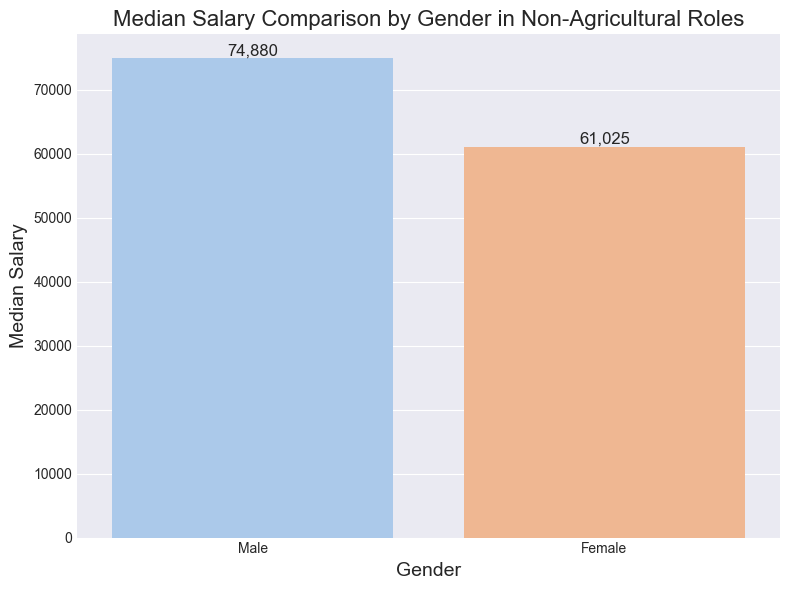

In [65]:
# Add a bar Graph

data = {
    'Gender': ['Male', 'Female'],
    'Median Salary': [74880, 61025]
}

salary_df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))

sns.barplot(x='Gender', y='Median Salary', data=salary_df, hue='Gender', palette='pastel', legend=False)

plt.title('Median Salary Comparison by Gender in Non-Agricultural Roles', fontsize=16)
plt.ylabel('Median Salary', fontsize=14)
plt.xlabel('Gender', fontsize=14)

for index, value in enumerate(salary_df['Median Salary']):
    plt.text(index, value + 500, f'{value:,}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()    

## Findings from Visualization

- The bar graph illustrates the salary disparity between the two genders. The median for male workers is 74,880 while the female workers earn less with 61,025.

## Research Question
__1. What type of job has the highest average salary in each region, considering only individuals who work in non-agricultural jobs?__
